In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lol-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2072626%2F3440676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T045226Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0ac695b48e2618ed0b07781aebbd6550cf98963d01f61f324db5a0dd016cfcf46bd06cf8e2205294d013a5712330acb547bf2562cca019b945d6c219b85773a4dd966897174b1c560d8cf3fbf80c75fc0838f07fc507f064742ea3d558c21692749920143e6bd19bf044c1bb3fad7bb5bac016aeb8223667e95763efde83cdb342e2db61468e9f760b1175bd7e6cd8e987ae12239242942eec440c2eeb316ada746cb4c96ebe9ade76d9f1997df83a9a03c9559f06567b93f3489efbbdff3ddec22a5a763f8f71170295306436dea579935e242171c39080e188a1124f91a6ccd8a965c0fccc416fdabfcd3f66ca9386f0a9f7082aba690afbfcea62ab20e247'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347140124 bytes downloaded
Downloaded and uncompressed: lol-dataset
Data source import complete.


# **Imports**

In [4]:
# Main
import os
import random
import tensorflow as tf
from tensorflow import keras

# Data
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model-
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from huggingface_hub import from_pretrained_keras

In [5]:
os.environ["KERAS_BACKEND"] = "tensorflow"

# Random Seed
SEED = 10
random.seed(SEED)
tf.random.set_seed(SEED)

# Directory Paths
train_imgs_path = "/kaggle/input/lol-dataset/lol_dataset/our485/"
eval_imgs_path = "/kaggle/input/lol-dataset/lol_dataset/eval15/"

# Data configs
CLASS_NAMES = sorted(["high", "low"])
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 4


# #N_RRGs = 3: Specifies the number of Residual Refinement Groups (RRGs) in the model.
# N_MRBs = 2: Specifies the number of Multi-scale Residual Blocks (MRBs) in the model.
# CHANNELS = 64: Specifies the number of channels in the model architecture.
# # Model Specific Constants
N_RRGs = 3
N_MRBs = 2
CHANNELS = 64

# **LOL Dataset**

The LOL (LOw Light) Dataset serves as a critical resource in the realm of low-light image enhancement research. Created to address the pressing need for standardized benchmarks in this domain, the LOL Dataset comprises a diverse collection of images captured under challenging low-light conditions. These images encapsulate a wide spectrum of scenarios, ranging from indoor scenes with dim lighting to outdoor environments under moonlight or street lamps.

Central to the utility of the LOL Dataset is its meticulous curation process, which ensures both diversity and authenticity in the provided images. To achieve this, the dataset incorporates a variety of scenes, encompassing different lighting conditions, environments, and subject matter. This diversity enables researchers to evaluate the robustness and generalization capabilities of low-light enhancement algorithms across a broad spectrum of real-world scenarios.

Moreover, the LOL Dataset includes ground truth images corresponding to each low-light input. These ground truth images serve as reference standards, depicting the same scenes captured under optimal lighting conditions. This facilitates objective evaluation of the effectiveness of low-light enhancement algorithms by providing a clear benchmark for comparison.

In [6]:
def load_image(filename):
    """
    Loads and preprocesses an image from the given filename.

    Args:
        filename (str): The path to the image file.

    Returns:
        image (tf.Tensor): Preprocessed image tensor.
    """
    image = tf.io.read_file(filename)
    image = tfi.decode_png(image, channels=3)
    image = tfi.resize(image, IMAGE_SIZE)
    image = tfi.convert_image_dtype(image, tf.float32)
    image = image / 255.
    return image

def show_image(image, show=False):
    """
    Displays the given image.

    Args:
        image (tf.Tensor): The image tensor to display.
        show (bool, optional): Whether to display the image. Defaults to False.
    """
    image = tf.squeeze(image)
    plt.imshow(image)
    plt.axis('off')

    if show:
        plt.show()

def show_images(dataset, model=None, n_rows=2, n_cols=2, skip=2, figsize=(10, 8), title_1="Low Light Image", title_2="High Quality Image"):
    """
    Displays a grid of low-light and high-quality images from the given dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing low-light and high-quality image pairs.
        model (tf.keras.Model, optional): A model to generate enhanced images. Defaults to None.
        n_rows (int, optional): Number of rows in the grid. Defaults to 5.
        n_cols (int, optional): Number of columns in the grid. Defaults to 2.
        skip (int, optional): Skip value for grid traversal. Defaults to 2.
        figsize (tuple, optional): Size of the figure. Defaults to (8, 15).
        title_1 (str, optional): Title for low-light images. Defaults to "Low Light Image".
        title_2 (str, optional): Title for high-quality images. Defaults to "High Quality Image".
    """
    lows, highs = next(iter(dataset.take(1)))

    plt.figure(figsize=figsize)

    if model is not None:
        n_cols = 3
        skip = 3
        enhanced = model.predict(lows, verbose=0)

    for i in range(1, (n_rows * n_cols) + 1, skip):
        high_image = highs[i]
        low_image = lows[i]

        plt.subplot(n_rows, n_cols, i)
        show_image(low_image)
        plt.title(title_1)

        plt.subplot(n_rows, n_cols, i + 1)
        show_image(high_image)
        plt.title(title_2)

        if model is not None:
            plt.subplot(n_rows, n_cols, i+2)
            show_image(enhanced[i])
            plt.title("Enhanced")

    plt.tight_layout()
    plt.show()

def random_crop(low_image, enhanced_image):
    """
    Randomly crops the low-light image and its corresponding enhanced image.

    Args:
        low_image (tf.Tensor): Low-light image tensor.
        enhanced_image (tf.Tensor): Enhanced image tensor.

    Returns:
        tf.Tensor: Cropped low-light image tensor.
        tf.Tensor: Cropped enhanced image tensor.
    """
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(shape=(), maxval=low_image_shape[1] - IMAGE_SIZE[0] + 1, dtype=tf.int32)
    low_h = tf.random.uniform(shape=(), maxval=low_image_shape[0] - IMAGE_SIZE[0] + 1, dtype=tf.int32)

    low_image_cropped = low_image[low_h : low_h + IMAGE_SIZE[0], low_w : low_w + IMAGE_SIZE[0]]
    enhanced_image_cropped = enhanced_image[low_h : low_h + IMAGE_SIZE[0], low_w : low_w + IMAGE_SIZE[0]]

    # Ensure cropped images have correct shapes
    low_image_cropped.set_shape([*IMAGE_SIZE, 3])
    enhanced_image_cropped.set_shape([*IMAGE_SIZE, 3])

    return low_image_cropped, enhanced_image_cropped


def preprocess(high_img_path, low_img_path):
    """
    Preprocesses a pair of high-quality and low-light images.

    Args:
        high_img_path (str): The path to the high-quality image file.
        low_img_path (str): The path to the low-light image file.

    Returns:
        high_img (tf.Tensor): Preprocessed high-quality image tensor.
        low_img (tf.Tensor): Preprocessed low-light image tensor.
    """
    high_img = load_image(high_img_path)
    low_img = load_image(low_img_path)
    return random_crop(high_img, low_img)

The number of training and testing files has been decreased to free up space for model training.

In [7]:
# Load the File Names
highq_imgs = glob(train_imgs_path + "high/*")[:300]
lowq_imgs = [path.replace("high", "low") for path in highq_imgs]

# Load the File Names
highq_eval_imgs = glob(eval_imgs_path + "high/*")[:100]
lowq_eval_imgs = [path.replace("high", "low") for path in highq_eval_imgs]

In [8]:
# Convert into Tensorflow Dataset
train_ds = tfd.Dataset.from_tensor_slices((lowq_imgs, highq_imgs))
train_ds = train_ds.map(preprocess).shuffle(300)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tfd.AUTOTUNE)

In [9]:
# Convert into Tensorflow Dataset
eval_ds = tfd.Dataset.from_tensor_slices((lowq_eval_imgs, highq_eval_imgs))
eval_ds = eval_ds.map(preprocess).shuffle(300)
eval_ds = eval_ds.batch(BATCH_SIZE).prefetch(tfd.AUTOTUNE)

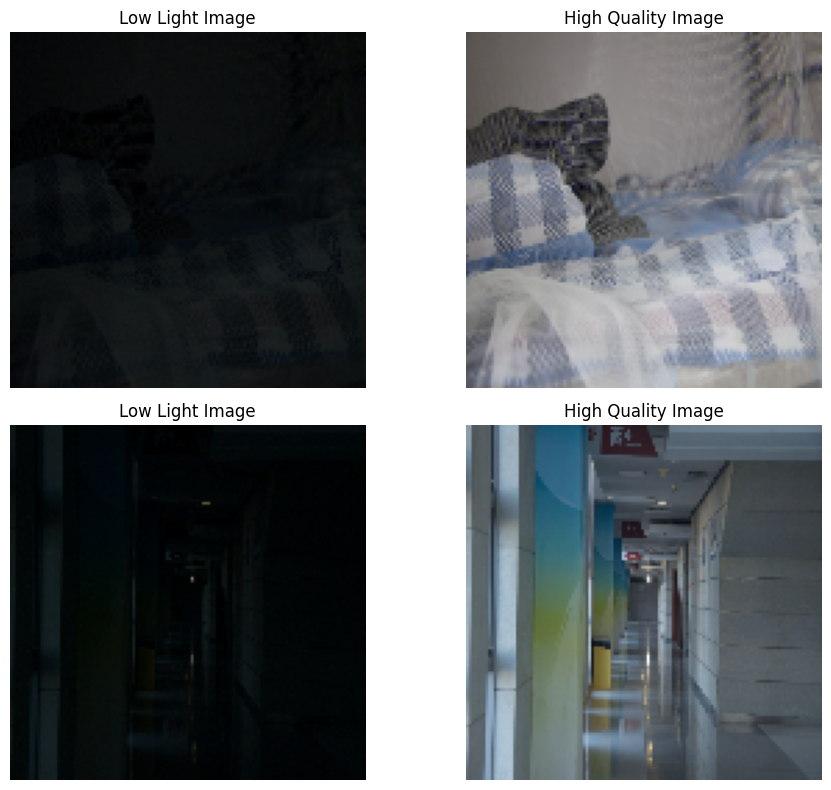

In [10]:
# Visualization
show_images(train_ds)

# **MIRNet**

# **Selective Kernel Feature Fusion (SKFF)**

In [11]:
def SKFF(multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3):
    """
    Selective Kernel Feature Fusion: Combines multi-scale features into a unified, recalibrated feature representation.

    Args:
        multi_scale_feature_1 (tf.Tensor): Multi-scale feature tensor from scale 1.
        multi_scale_feature_2 (tf.Tensor): Multi-scale feature tensor from scale 2.
        multi_scale_feature_3 (tf.Tensor): Multi-scale feature tensor from scale 3.

    Returns:
        unified_recalibrated (tf.Tensor): Unified and recalibrated feature tensor.
    """
    # Collecting channel information
    n_channels = list(multi_scale_feature_1.shape)[-1]

    # Addition Layer
    unified_features = layers.Add()([multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3])

    # Global Average Pooling
    global_avg = layers.GlobalAveragePooling2D()(unified_features)

    # Conversion to single channel
    channels = layers.Reshape((1, 1, n_channels))(global_avg)

    # Compact Channel Feature Representation
    compact_channels = layers.Conv2D(
        filters=n_channels//8,
        kernel_size=1,
        activation="relu",
    )(channels)

    # Multi Scale Feature Descriptors
    feature_descriptor_1 = layers.Conv2D(
        filters=n_channels,
        kernel_size=1,
        activation="softmax",
    )(compact_channels)

    feature_descriptor_2 = layers.Conv2D(
        filters=n_channels,
        kernel_size=1,
        activation="softmax",
    )(compact_channels)

    feature_descriptor_3 = layers.Conv2D(
        filters=n_channels,
        kernel_size=1,
        activation="softmax",
    )(compact_channels)

    # Recalibrated Feature Descriptions
    recalibrated_1 = layers.Multiply()([multi_scale_feature_1, feature_descriptor_1])
    recalibrated_2 = layers.Multiply()([multi_scale_feature_2, feature_descriptor_2])
    recalibrated_3 = layers.Multiply()([multi_scale_feature_3, feature_descriptor_3])

    # Unified Recalibrated Features
    unified_recalibrated = layers.Add()([recalibrated_1, recalibrated_2, recalibrated_3])

    return unified_recalibrated


In [12]:
# Create Dummy Features
features = tf.ones(shape=(32, 12, 12, 32), dtype=tf.float32)

# Testing the working
SKFF(features, features, features).shape

TensorShape([32, 12, 12, 32])

# **Dual Attention Unit (DAU)**

In [13]:
class ChannelPooling(layers.Layer):
    """
    Custom layer to perform channel pooling operations.

    This layer computes average pooling and max pooling along the channel dimension of the input tensor
    and concatenates the results.

    Args:
        axis (int, optional): The axis along which to perform pooling. Defaults to -1.

    Attributes:
        axis (int): The axis along which pooling is performed.

    Methods:
        call(inputs): Performs channel pooling on the input tensor.
        get_config(): Returns the configuration of the layer.
    """

    def __init__(self, axis=-1, **kwargs):
        """
        Initializes the ChannelPooling layer.

        Args:
            axis (int, optional): The axis along which to perform pooling. Defaults to -1.
        """
        super().__init__(**kwargs)
        self.axis = axis
        self.concat = layers.Concatenate(axis=self.axis)

    def call(self, inputs):
        """
        Performs channel pooling on the input tensor.

        Args:
            inputs (tf.Tensor): The input tensor.

        Returns:
            tf.Tensor: Concatenated tensor containing average and max pooled channels.
        """

        # #Average Pooling: Average pooling computes the average value of each channel in a specified region of the input tensor.
        # This operation helps to downsample the input tensor spatially, reducing its size while retaining important information.
        # In this case, average pooling is performed along the channel dimension, meaning that the average value of each channel is calculated independently
        # of the values in other channels.

        # Max Pooling: Max pooling computes the maximum value of each channel in a specified region of the input tensor.
        # Like average pooling, it helps to downsample the input tensor spatially, retaining only the most significant features.
        # Max pooling, like average pooling, is performed along the channel dimension in this case.



        average_pooling = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        max_pooling = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        return self.concat([average_pooling, max_pooling])

    def get_config(self):
        """
        Returns the configuration of the layer.

        Returns:
            dict: Configuration of the layer.
        """
        config = super().get_config()
        config.update({"axis": self.axis})
        return config


In [14]:
def SpatialAttentionBlock(input_features):
    """
    Spatial Attention Block: Generates a spatial attention map to recalibrate input features.

    Args:
        input_features (tf.Tensor): Input features tensor.

    Returns:
        tf.Tensor: Recalibrated input features tensor.
    """
    features = ChannelPooling()(input_features)
    features = layers.Conv2D(filters=1, kernel_size=1)(features)
    features = layers.Activation('sigmoid')(features)
    return layers.Multiply()([features, input_features])

In [15]:
def ChannelAttentionBlock(input_features):
    """
    Channel Attention Block: Generates a channel attention map to recalibrate input features.

    Args:
        input_features (tf.Tensor): Input features tensor.

    Returns:
        tf.Tensor: Recalibrated input features tensor.
    """
    channels = list(input_features.shape)[-1]
    features = layers.GlobalAveragePooling2D()(input_features)
    features = layers.Reshape((1, 1, channels))(features)
    features = layers.Conv2D(
        filters=channels // 8,
        kernel_size=1,
        activation="relu",
        kernel_initializer="he_normal"
    )(features)
    features = layers.Conv2D(
        filters=channels,
        kernel_size=1,
        activation="sigmoid"
    )(features)
    return layers.Multiply()([features, input_features])

In [16]:
def DAU(input_features):
    """
    Dual Attention Unit (DAU): Applies spatial and channel attention mechanisms to input features.

    Args:
        input_features (tf.Tensor): Input features tensor.

    Returns:
        tf.Tensor: Output tensor after applying DAU.
    """
    channels = list(input_features.shape)[-1]
    features = layers.Conv2D(
        filters=channels,
        kernel_size=3,
        padding="same",
        activation="relu"
    )(input_features)
    features = layers.Conv2D(
        filters=channels,
        kernel_size=3,
        padding="same"
    )(features)

    spatial_attention = SpatialAttentionBlock(features)
    channel_attention = ChannelAttentionBlock(features)

    features = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    features = layers.Conv2D(channels, kernel_size=1)(features)

    return layers.Add()([input_features, features])


In [17]:
# Checking for any errors
features = tf.ones(shape=(12, 4, 4, 32))
DAU(features).shape

TensorShape([12, 4, 4, 32])

# **Multi-Scale Residual Block (MRB)**

In [18]:
def DownSamplingBlock(input_features):
    """
    DownSampling Block: Performs downsampling on input features while preserving important information.

    This block consists of two parallel pathways: the main pathway and the skip pathway. In the main pathway,
    the input features undergo two convolutional layers followed by max pooling, reducing the spatial dimensions
    while increasing the number of channels. In the skip pathway, max pooling is applied directly to the input
    features to match the spatial dimensions of the main pathway. Both pathways then undergo convolutional operations
    to adjust the number of channels. Finally, the output tensors from both pathways are added element-wise to
    preserve important information from the original input features.

    Args:
        input_features (tf.Tensor): Input features tensor.

    Returns:
        tf.Tensor: Output tensor after downsampling.
    """
    channels = list(input_features.shape)[-1]

    main_features = layers.Conv2D(
        filters=channels,
        kernel_size=1,
        activation="relu",
        kernel_initializer="he_normal"
    )(input_features)
    main_features = layers.Conv2D(
        filters=channels,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(main_features)

    main_features = layers.MaxPooling2D()(main_features)
    main_features = layers.Conv2D(channels * 2, kernel_size=1)(main_features)

    skip_features = layers.MaxPooling2D()(input_features)
    skip_features = layers.Conv2D(channels * 2, kernel_size=1)(skip_features)

    return layers.Add()([main_features, skip_features])


In [19]:
def UpSamplingBlock(input_features):
    """
    UpSampling Block: Performs upsampling on input features while preserving important information.

    This block consists of two parallel pathways: the main pathway and the skip pathway. In the main pathway,
    the input features undergo two convolutional layers followed by upsampling, increasing the spatial dimensions
    while decreasing the number of channels. In the skip pathway, upsampling is applied directly to the input
    features to match the spatial dimensions of the main pathway. Both pathways then undergo convolutional operations
    to adjust the number of channels. Finally, the output tensors from both pathways are added element-wise to
    preserve important information from the original input features.

    Args:
        input_features (tf.Tensor): Input features tensor.

    Returns:
        tf.Tensor: Output tensor after upsampling.
    """
    channels = list(input_features.shape)[-1]

    main_features = layers.Conv2D(
        filters=channels,
        kernel_size=1,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal"
    )(input_features)
    main_features = layers.Conv2D(
        filters=channels,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal"
    )(main_features)

    main_features = layers.UpSampling2D()(main_features)
    main_features = layers.Conv2D(channels // 2, kernel_size=1)(main_features)

    skip_features = layers.UpSampling2D()(input_features)
    skip_features = layers.Conv2D(channels // 2, kernel_size=1)(skip_features)

    return layers.Add()([main_features, skip_features])


In [20]:
def MRB(input_features, channels):
    """
    Multi-Scale Residual Block (MRB): Combines downscaling, dual attention mechanisms, and selective kernel feature fusion.

    Args:
        input_features (tf.Tensor): Input feature tensor.
        channels (int): Number of output channels.

    Returns:
        tf.Tensor: Output tensor after passing through the MRB.
    """
    # Downscaling the features
    scale_1 = input_features
    scale_2 = DownSamplingBlock(input_features)
    scale_3 = DownSamplingBlock(scale_2)

    # Dual Attention Units
    dual_attention_1 = DAU(scale_1)
    dual_attention_2 = DAU(scale_2)
    dual_attention_3 = DAU(scale_3)

    # Selective Kernel Feature Fusion
    skff_1 = SKFF(
        dual_attention_1,
        UpSamplingBlock(dual_attention_2),
        UpSamplingBlock(UpSamplingBlock(dual_attention_3))
    )
    skff_2 = SKFF(
        DownSamplingBlock(dual_attention_1),
        dual_attention_2,
        UpSamplingBlock(dual_attention_3)
    )
    skff_3 = SKFF(
        DownSamplingBlock(DownSamplingBlock(dual_attention_1)),
        DownSamplingBlock(dual_attention_2),
        dual_attention_3
    )

    # Dual Attention units
    dau_1 = DAU(skff_1)
    dau_2 = UpSamplingBlock(DAU(skff_2))
    dau_3 = UpSamplingBlock(UpSamplingBlock(DAU(skff_3)))

    # Selective Kernel Feature Fusion
    skff = SKFF(dau_1, dau_2, dau_3)
    mrb_out = layers.Conv2D(channels, kernel_size=3, padding="same")(skff)

    return layers.Add()([input_features, mrb_out])


In [21]:
MRB(features, 32).shape

TensorShape([12, 4, 4, 32])

# **Recursive Residual Group**

In [22]:
def RRG(input_feature, n_mrbs, channels):
    """
    Recursive Residual Group (RRG): Constructs a group of MRBs with recursive connections.

    Args:
        input_feature (tf.Tensor): Input feature tensor.
        n_mrbs (int): Number of Multi-Scale Residual Blocks (MRBs) in the group.
        channels (int): Number of output channels.

    Returns:
        tf.Tensor: Output tensor after passing through the recursive residual group.
    """
    feature = layers.Conv2D(channels, kernel_size=3, padding="same")(input_feature)
    for _ in range(n_mrbs):
        feature = MRB(feature, channels)
    feature = layers.Conv2D(channels, kernel_size=3, padding="same")(feature)

    return layers.Add()([feature, input_feature])

# **MIRNet Network**

Let's integrate all the components to build the complete MIRNet model. We'll assemble the building blocks including the Multi-Scale Residual Block (MRB), the Recursive Residual Group (RRG), and other necessary components. With these, we can construct a powerful model for low-light image enhancement.

In [23]:
# Low Light Image Input Layer
low_light_image_input = layers.Input(shape=(*IMAGE_SIZE, 3), name="LowLightImageInput")

# Extract image features
features = layers.Conv2D(CHANNELS, kernel_size=3, padding="same")(low_light_image_input)

# Apply RRGs
for _ in range(N_RRGs):
    features = RRG(features, N_MRBs, CHANNELS)

# Final Transformation
features = layers.Conv2D(3, kernel_size=3, padding="same")(features)

# Final Outputs
high_quality_gen_image = layers.Add()([low_light_image_input, features])

# Model
mirnet = Model(low_light_image_input, high_quality_gen_image, name="MIRNet")

In [24]:
# Model Visualization : This will be a little complex
# tf.keras.utils.plot_model(mirnet, to_file="MIRNet.png", show_shapes=True)

# **MIRNet Training**

In [25]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

In [26]:
# # Model Compilation
# optimizer = keras.optimizers.Adam(learning_rate=1e-1)
# mirnet.compile(
#     optimizer=optimizer,
#     loss=charbonnier_loss,
#     metrics=[peak_signal_noise_ratio],
# )

# # Model Training
# history = mirnet.fit(
#     train_ds,
#     validation_data=eval_ds,
#     epochs=50,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(
#             monitor="val_peak_signal_noise_ratio",
#             factor=0.5,
#             patience=5,
#             verbose=1,
#             min_delta=1e-7,
#             mode="max",
#         )
#     ],
# )

Training the model from scratch can be a time-consuming process due to the large number of parameters involved. To expedite this process and benefit from existing knowledge, we'll leverage a pretrained model. Utilizing a pretrained model offers several advantages, including speed and accuracy. Additionally, we have the flexibility to fine-tune the pretrained model if necessary, allowing us to adapt it to our specific task or dataset. This approach enables us to achieve impressive results efficiently, making the most of available resources and expertise.

# **MIRNet Inference**

Loading the model without compiling it indicates our intention to utilize it solely for inference purposes, rather than training. This approach allows us to leverage the pretrained model's capabilities without the need for further optimization or adjustments.

In [27]:
# Set the model checkpoint/location
model_checkpoint = 'keras-io/lowlight-enhance-mirnet'

# Load the model without Compiling
mirnet = from_pretrained_keras(model_checkpoint, compile=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

demo.png:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

model.png:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/219k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/2.19M [00:00<?, ?B/s]

(…)fevents.1645063719.e472ca747184.299.0.v2:   0%|          | 0.00/4.56M [00:00<?, ?B/s]

(…)fevents.1645063841.e472ca747184.299.1.v2:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

(…)fevents.1645062781.9310af7fd322.357.0.v2:   0%|          | 0.00/481k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/437M [00:00<?, ?B/s]

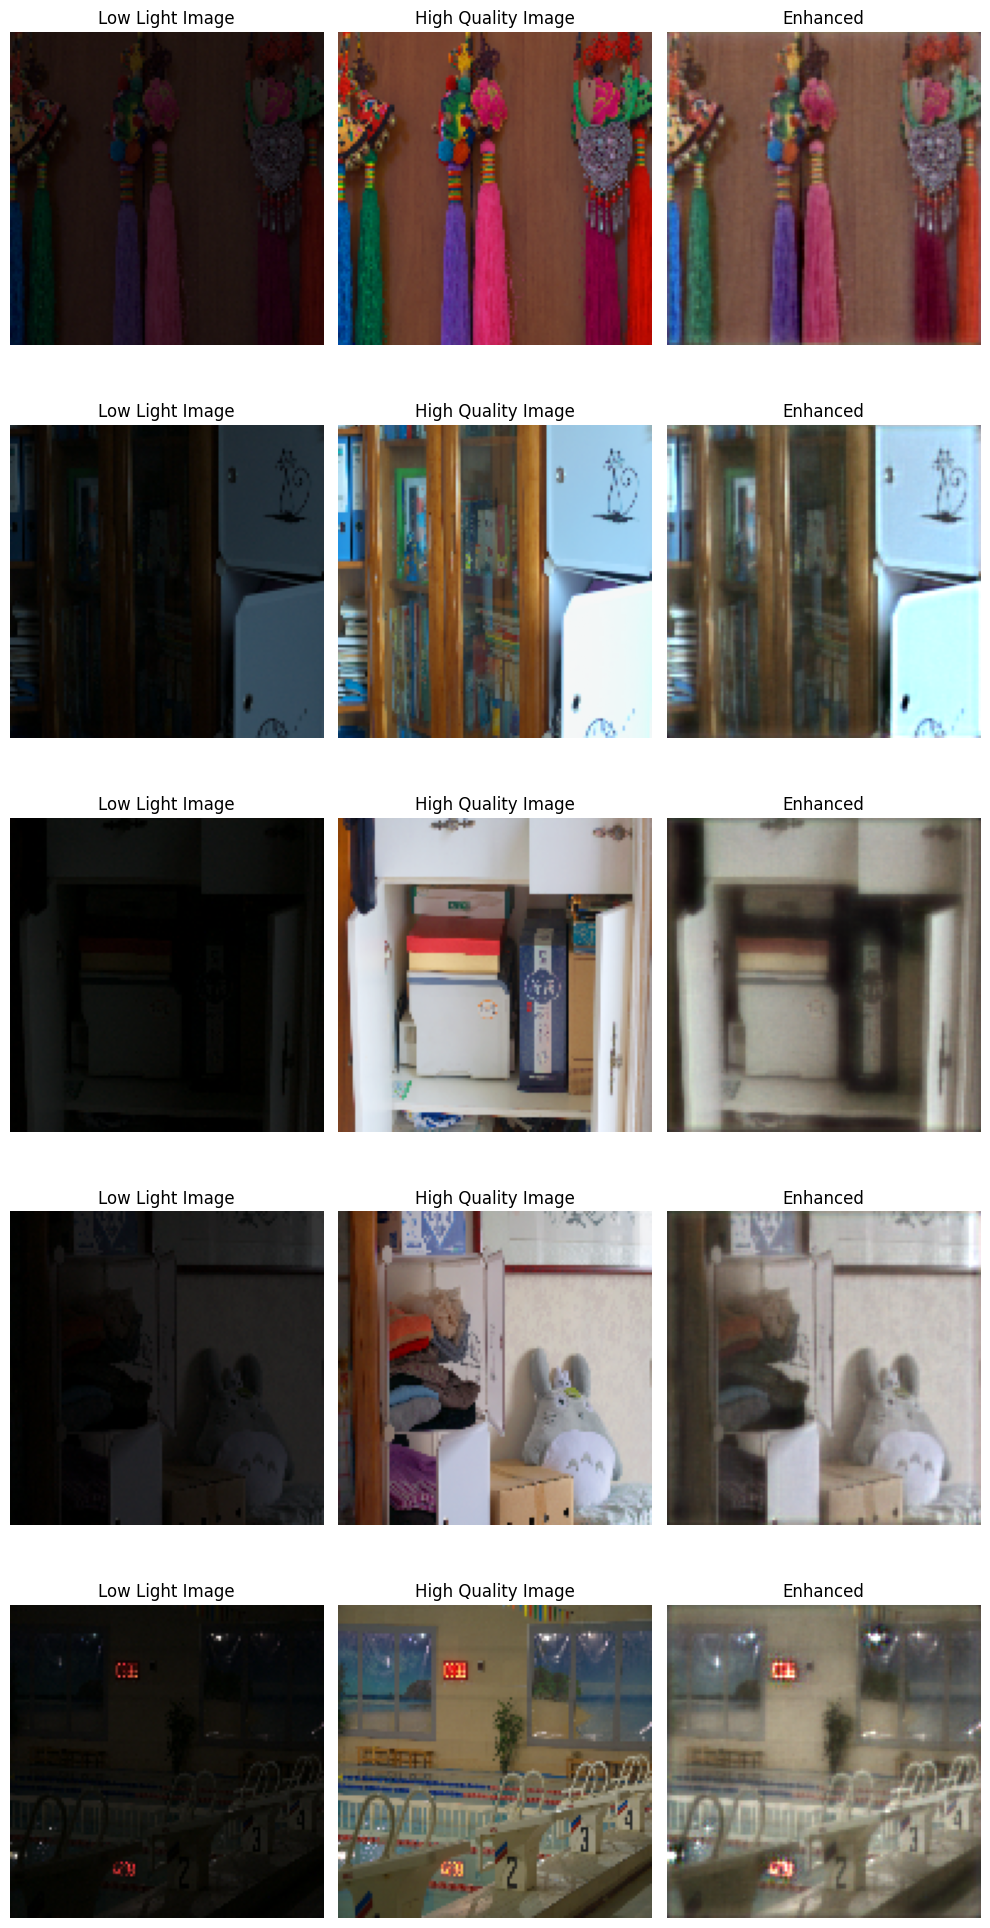

In [28]:
# Visualization
show_images(eval_ds.unbatch().batch(32), model=mirnet, n_rows=5, figsize=(10, 20))

It's evident that our low-light image enhancement model is yielding promising results. There's a noticeable improvement in terms of brightness, aligning with our expectations. The preservation of colors is commendable, maintaining the integrity of the original image while enhancing its luminosity. However, it's worth noting that the generated images still exhibit some blurriness, particularly in extremely dark conditions. Despite this, when comparing the original low-quality images with their enhanced counterparts, the enhancements are evident, contributing to overall image clarity.

